# Week 7 Data acqusition from Biosemi

In [19]:
# import require library for preprocess
import mne
import numpy as np
from mne.channels import make_standard_montage
import matplotlib.pyplot as plt
from mne.datasets import eegbci
import scipy
import pickle
import seaborn as sns
from scipy.signal import filtfilt

# import require library for classification
from sklearn.svm import SVC # SVM library
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA library
from sklearn.neighbors import KNeighborsClassifier # KNN library

from sklearn.metrics import classification_report,confusion_matrix # Result representation

## 1 Read recorded data from Biosemi (bdf file)

In [20]:
# read biosami file (bdf)
raw_bio = mne.io.read_raw_bdf("data/test1.bdf", preload=True) 
eegbci.standardize(raw_bio)

# Set channel location for data
montage = make_standard_montage("biosemi64")
raw_bio.set_montage(montage, on_missing='ignore')

Extracting EDF parameters from c:\git\BCI-Class-Material\Week7-signal_acqusition\data\test1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 204799  =      0.000 ...   399.998 secs...


Measurement date,"January 30, 2026 15:54:44 GMT"
Experimenter,Unknown
Participant,
Digitized points,67 points
Good channels,"73 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.00 Hz
Lowpass,104.00 Hz


In [21]:
raw_bio = raw_bio.resample(128, verbose = False)
raw_bio

Measurement date,"January 30, 2026 15:54:44 GMT"
Experimenter,Unknown
Participant,
Digitized points,67 points
Good channels,"73 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,128.00 Hz
Highpass,0.00 Hz
Lowpass,64.00 Hz


**check channel names**

In [22]:
raw_bio.ch_names

['Fp1',
 'AF7',
 'AF3',
 'F1',
 'F3',
 'F5',
 'F7',
 'FT7',
 'FC5',
 'FC3',
 'FC1',
 'C1',
 'C3',
 'C5',
 'T7',
 'TP7',
 'CP5',
 'CP3',
 'CP1',
 'P1',
 'P3',
 'P5',
 'P7',
 'P9',
 'PO7',
 'PO3',
 'O1',
 'Iz',
 'Oz',
 'POz',
 'Pz',
 'CPz',
 'Fpz',
 'Fp2',
 'AF8',
 'AF4',
 'AFz',
 'Fz',
 'F2',
 'F4',
 'F6',
 'F8',
 'FT8',
 'FC6',
 'FC4',
 'FC2',
 'FCz',
 'Cz',
 'C2',
 'C4',
 'C6',
 'T8',
 'TP8',
 'CP6',
 'CP4',
 'CP2',
 'P2',
 'P4',
 'P6',
 'P8',
 'P10',
 'PO8',
 'PO4',
 'O2',
 'EXG1',
 'EXG2',
 'EXG3',
 'EXG4',
 'EXG5',
 'EXG6',
 'EXG7',
 'EXG8',
 'GSR1',
 'STATUS']

In [23]:
# raw_bio.plot(start = 100, duration = 15)
# print('...')

## 2. Apply filter

**raw data PSD plotting**

Effective window size : 16.000 (s)


C:\Users\pipo_\AppData\Local\Temp\ipykernel_21316\227901645.py:2: UserWarning: Zero value in spectrum for channel GSR1
  raw_bio.compute_psd(fmax=60).plot(picks=select_channels)
c:\git\BCI-Class-Material\.venv\Lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


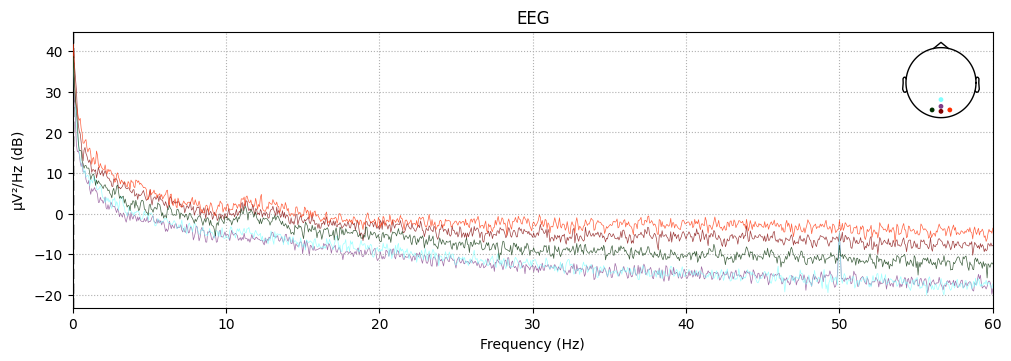

In [24]:
select_channels = ['O1', 'Oz', 'O2', 'Pz', 'POz']
raw_bio.compute_psd(fmax=60).plot(picks=select_channels)
plt.show()

**apply notch and band-pass filter**

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower pass

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Effective window size : 16.000 (s)


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
c:\git\BCI-Class-Material\.venv\Lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


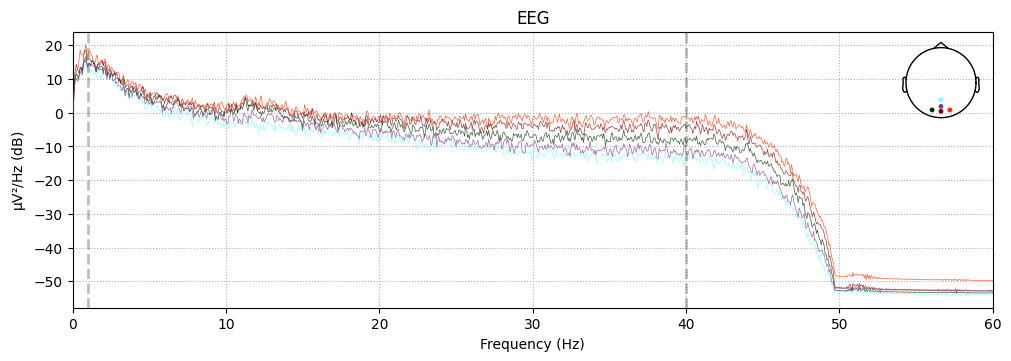

In [25]:
raw_bio = raw_bio.set_eeg_reference('average')  
bio_filter = raw_bio.copy().filter(l_freq=1, h_freq=40) #band-pass function
bio_filter = bio_filter.copy().notch_filter(freqs=50) #notch filter function
bio_filter.compute_psd(fmax=60).plot(picks=select_channels)
plt.show()

# 3. Data Epoching

**Biosemi**

In [26]:
events = mne.find_events(raw_bio, shortest_event = 0) #command for get events and timestamp

#Define what event numbers is
event_dict =  {'12Hz': 8,
'24Hz': 4,
'6Hz': 10,
'30Hz': 2,
'trial_begin': 1,
'trial_end': 20,
'end_exper': 40
}
print(events)

Trigger channel STATUS has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
121 events found on stim channel STATUS
Event IDs: [ 1  2  4  8 10 20 40]
[[ 2051     0     1]
 [ 2179     0     4]
 [ 2819     0    20]
 [ 3076     0     1]
 [ 3205     0    10]
 [ 3845     0    20]
 [ 4101     0     1]
 [ 4229     0    10]
 [ 4869     0    20]
 [ 5125     0     1]
 [ 5254     0     4]
 [ 5893     0    20]
 [ 6150     0     1]
 [ 6278     0    10]
 [ 6918     0    20]
 [ 7174     0     1]
 [ 7303     0     8]
 [ 7943     0    20]
 [ 8199     0     1]
 [ 8327     0     2]
 [ 8968     0    20]
 [ 9224     0     1]
 [ 9352     0     4]
 [ 9992     0    20]
 [10248     0     1]
 [10377     0     8]
 [11017     0    20]
 [11274     0     1]
 [11402     0     8]
 [12042     0    20]
 [12298     0     1]
 [12426     0     2]
 [13067     0    20]
 [13323     0     1]
 [13452     0     2]
 [14092 

In [27]:
Bio_Epochs = mne.Epochs(raw_bio, events, 
    tmin= -1.0,  
    tmax= 5.0,    
    event_id=event_dict,
    preload = True,
    event_repeated='drop',
    baseline=(-1.0, 0.0),
    verbose=True
    )

Not setting metadata
121 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 121 events and 769 original time points ...
0 bad epochs dropped


In [28]:
Bio_Epochs

Number of events,121
Events,12Hz: 1024Hz: 1030Hz: 106Hz: 10end_exper: 1trial_begin: 40trial_end: 40
Time range,-1.000 – 5.000 s
Baseline,-1.000 – 0.000 s


In [29]:
# Bio_Epochs.plot(n_epochs = 5)
# print('...')

## 4.PSD plotting

    Using multitaper spectrum estimation with 7 DPSS windows


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Averaging across epochs...
Averaging across epochs...
Averaging across epochs...


c:\git\BCI-Class-Material\.venv\Lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


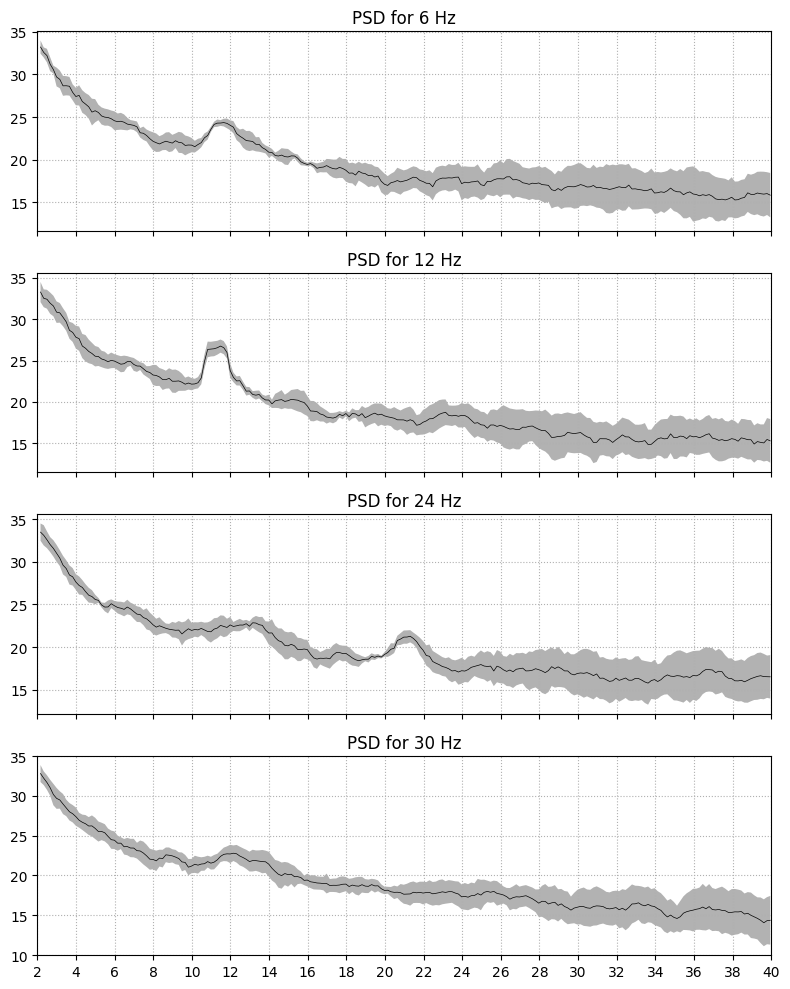

In [30]:
# Compute the PSD for different frequency epochs
ssvep_chans = ['O1','Oz','O2'] 
psd_6Hz = Bio_Epochs['6Hz'].pick(ssvep_chans).compute_psd(fmin=2.0, fmax=40.0)
psd_12Hz = Bio_Epochs['12Hz'].pick(ssvep_chans).compute_psd(fmin=2.0, fmax=40.0)
psd_24Hz = Bio_Epochs['24Hz'].pick(ssvep_chans).compute_psd(fmin=2.0, fmax=40.0)
psd_30Hz = Bio_Epochs['30Hz'].pick(ssvep_chans).compute_psd(fmin=2.0, fmax=40.0)

# Store PSD objects and titles
psd_data = [(psd_6Hz, '6 Hz'), (psd_12Hz, '12 Hz'), (psd_24Hz, '24 Hz'), (psd_30Hz, '30 Hz')]

# Create subplots (1 column, 4 rows)
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 10), sharex=True)

# Plot each PSD computation in a separate subplot
for ax, (psd, title) in zip(axes, psd_data):
    psd.plot(average=True, amplitude=False, picks="data", exclude="bads", axes=ax)
    ax.set_title(f'PSD for {title}')
    ax.set_xticks(np.arange(2, 41, 2))  # Set x-axis ticks from 2 to 60 Hz
    ax.set_xticklabels(np.arange(2, 41, 2))  # Set x-axis labels

plt.tight_layout()
plt.show()